In [1]:
from matplotlib import pyplot as plt
import matplotlib
import geopandas as gpd
import pandas as pd
import numpy as np
import shapely.geometry as shp
from shapely.geometry import Point
from shapely.validation import explain_validity
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable



# import contextily as ctx


CRS_LAT_LON = "epsg:4326"
# CRS_WGS84 = "EPSG:32719"
CRS_WGS84 = "EPSG:3857"
CRS_CHILE19S = "EPSG:20049"

In [2]:
colegios_raw = pd.read_excel('Colegios2020.xlsx',header=0)

In [4]:
colegios = colegios_raw[['Num.RBD', 'Latitud', 'Longitud']]
colegios = gpd.GeoDataFrame(
    colegios, geometry=gpd.points_from_xy(colegios['Longitud'], colegios['Latitud']), crs=CRS_LAT_LON
)
colegios = colegios.to_crs(CRS_WGS84)
colegios_fil = colegios[ (colegios['Latitud']!=0) & (colegios['Longitud']!=0)]

colegios_na = colegios[ (colegios['Latitud']==0) | (colegios['Longitud']==0)]


len(colegios_fil) == len(colegios) - len(colegios_na)

True

In [5]:
comunas_raw = gpd.read_file('Comunas/comunas.shp')

In [6]:
comunas_raw['Region'].unique()

array(["Región del Libertador Bernardo O'Higgins",
       'Región de La Araucanía', 'Región Metropolitana de Santiago',
       'Región de Los Lagos', 'Región de Los Ríos', 'Región del Maule',
       'Región de Coquimbo', 'Región de Magallanes y Antártica Chilena',
       'Zona sin demarcar', 'Región de Valparaíso', 'Región del Bío-Bío',
       'Región de Aysén del Gral.Ibañez del Campo', 'Región de Tarapacá',
       'Región de Arica y Parinacota', 'Región de Antofagasta',
       'Región de Ñuble', 'Región de Atacama'], dtype=object)

In [7]:
comunas_raw[comunas_raw['Region']=='Región de Valparaíso']['Comuna'].unique()

array(['Rinconada', 'Cabildo', 'Petorca', 'Panquehue', 'Olmué',
       'Cartagena', 'Catemu', 'Llaillay', 'San Felipe', 'Santa María',
       'Villa Alemana', 'Santo Domingo', 'San Antonio', 'El Tabo',
       'El Quisco', 'Algarrobo', 'Casablanca', 'Valparaíso',
       'Viña del Mar', 'Concón', 'Quintero', 'Puchuncaví', 'Zapallar',
       'Papudo', 'La Ligua', 'Juan Fernández', 'Isla de Pascua',
       'Limache', 'Quillota', 'Calera', 'Nogales', 'Calle Larga',
       'La Cruz', 'Putaendo', 'San Esteban', 'Los Andes', 'Hijuelas',
       'Quilpué'], dtype=object)

In [8]:
comunas = comunas_raw[(comunas_raw['Comuna']!='Isla de Pascua') & (comunas_raw['Comuna']!='Juan Fernández')]
comunas = comunas.to_crs(CRS_WGS84)

In [9]:
comunas.crs == colegios_fil.crs

True

In [10]:
columns_invalid_comunas = comunas[~comunas.is_valid]

In [11]:
columns_invalid_comunas.geometry = columns_invalid_comunas.buffer(0) # Para sacar comunas inválidas

c:\Users\minso\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [12]:
comunas_clean = pd.concat([comunas[comunas.is_valid], columns_invalid_comunas])

In [13]:
comunas_clean.to_file("comunas_fixed/comunas_fixed.shp", index=False)

In [14]:
colegios_chile = colegios_fil.clip(comunas_clean.unary_union)

<Axes: >

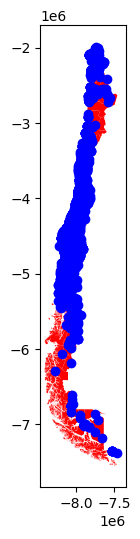

In [17]:
fig,ax=plt.subplots(1,1,figsize=(8,6))
comunas_clean.plot(ax=ax, color = "red", zorder=2, alpha=1)
colegios_chile.plot(ax=ax, color = "blue", zorder=3, alpha=1)

<Axes: >

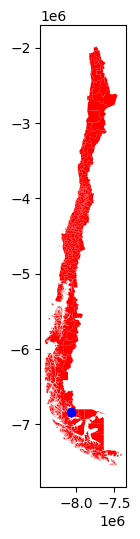

In [16]:
fig,ax=plt.subplots(1,1,figsize=(8,6))
comunas_clean.plot(ax=ax, color = "red", zorder=2, alpha=1)
colegios_chile[colegios_chile["Num.RBD"]==24322].plot(ax=ax, color = "blue", zorder=3, alpha=1)

In [19]:
colegios_chile_saved = colegios_chile.drop(["Latitud", "Longitud"], axis=1)

In [20]:
colegios_chile_saved.head()

,Num.RBD,geometry
7823,24322,POINT (-8068170.386 -6838195.805)
8449,40262,POINT (-8069732.563 -6752604.608)
4907,8421,POINT (-8069954.765 -6752600.862)
9001,886772,POINT (-8070681.573 -6752548.309)
4901,8413,POINT (-8070414.238 -6752511.033)


In [21]:
colegios_chile_saved["x"] = colegios_chile_saved.geometry.x
colegios_chile_saved["y"] = colegios_chile_saved.geometry.y

In [22]:
colegios_chile_saved["values"] = 14*colegios_chile_saved["x"] + 2*colegios_chile_saved["y"] + 4*10000

In [23]:
x = colegios_chile_saved["x"]
y = colegios_chile_saved["y"]

points=np.array([[x_aux,y_aux] for x_aux,y_aux, in zip(x, y)])
values =np.array([z for z in colegios_chile_saved["values"]])

In [24]:
def show_schools_and_comunas(comunas, x_colegios, y_colegios, values_colegios):
    x_min = x_colegios.min()
    x_max = x_colegios.max()
    y_min = y_colegios.min()
    y_max = y_colegios.max()

    n_resolution = 100
    grid_x, grid_y = np.mgrid[x_min:x_max:(x_max-x_min)/n_resolution, y_min:y_max:(y_max-y_min)/n_resolution]
    print(grid_x.shape,grid_y.shape)

    fig,ax=plt.subplots(1,1,figsize=(15,15))
    cax = make_axes_locatable(ax).append_axes("right", size="5%", pad="2%")

    im=ax.scatter(x_colegios,y_colegios,c=values_colegios,cmap='Blues')
    comunas.boundary.plot(ax=ax,color='k',lw=0.2)
    # ax.plot(grid_x, grid_y, marker='.', markersize=1,color='k', linestyle='none')
    plt.colorbar(im,ax=ax,cax=cax);


(100, 100) (100, 100)


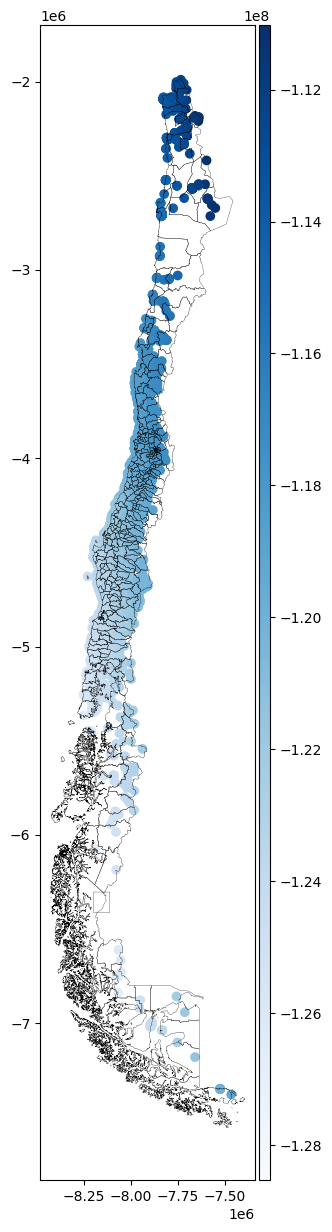

In [25]:
show_schools_and_comunas(comunas_clean, x, y, values)

In [26]:
colegios_chile_proyected = colegios_chile_saved.to_crs(CRS_CHILE19S)
x_proyected = colegios_chile_proyected.geometry.x
y_proyected = colegios_chile_proyected.geometry.y
comunas_proyected = comunas_clean.to_crs(CRS_CHILE19S)

(100, 100) (100, 100)


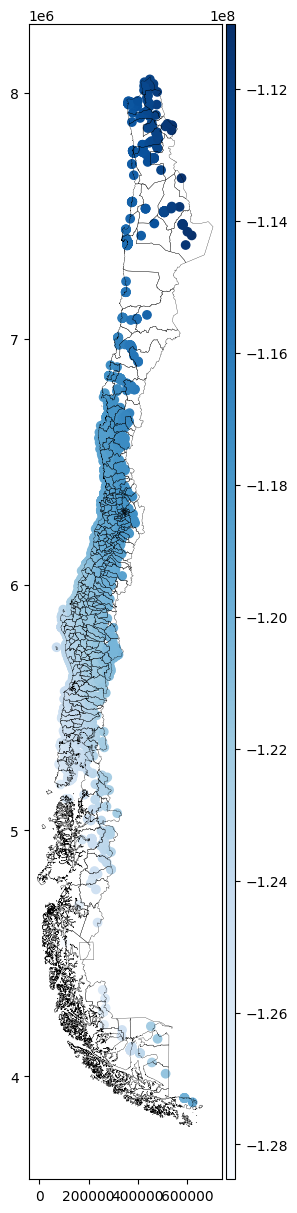

In [27]:
show_schools_and_comunas(comunas_proyected, x_proyected, y_proyected, values)

In [35]:
comuna_aux = comunas_clean[comunas_clean["Region"]== 'Región de La Araucanía']
colegios_aux = colegios_chile_saved.clip(comuna_aux)

(100, 100) (100, 100)


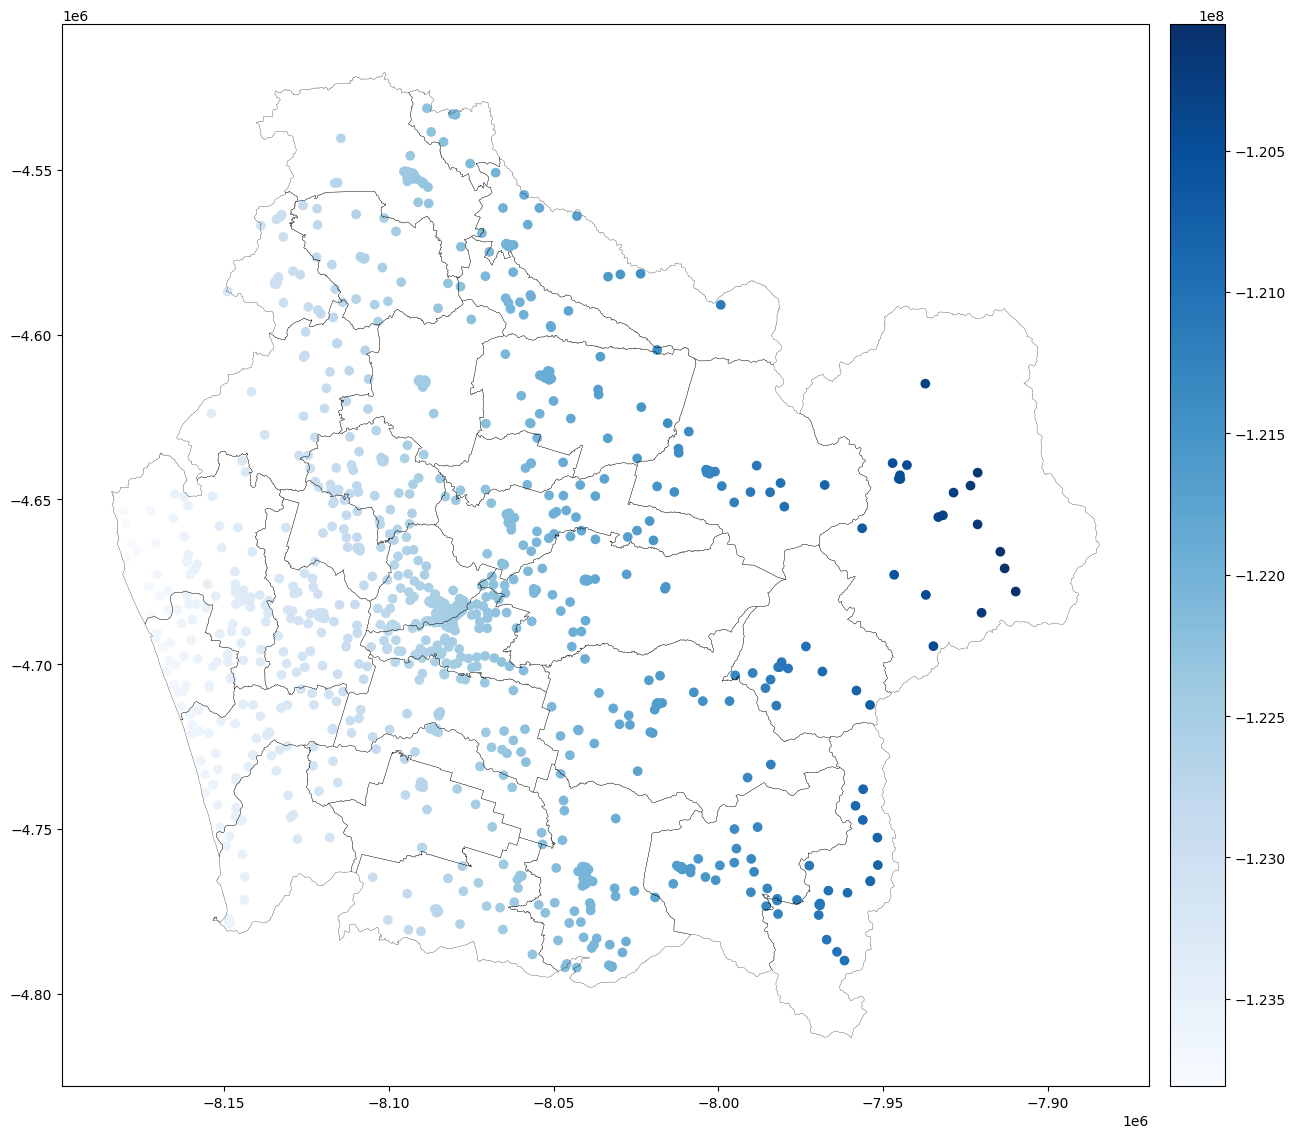

In [36]:
x_aux = colegios_aux.geometry.x
y_aux = colegios_aux.geometry.y
values_aux = colegios_aux["values"]
show_schools_and_comunas(comuna_aux, x_aux, y_aux, values_aux)

(100, 100) (100, 100)


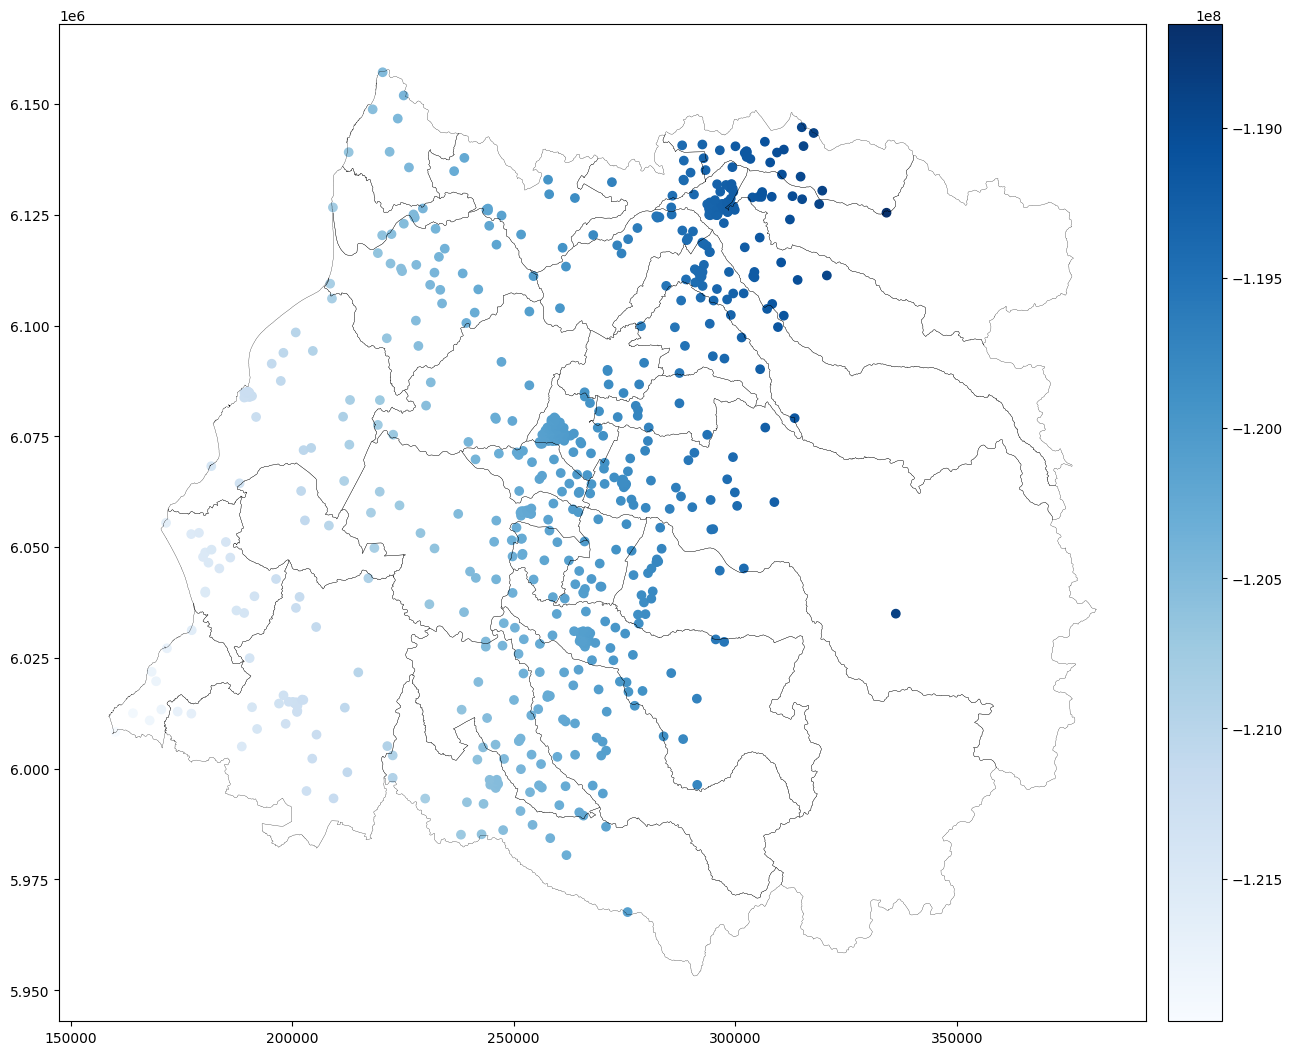

In [40]:
x_aux_proyected = colegios_aux.to_crs(CRS_CHILE19S).geometry.x
y_aux_proyected = colegios_aux.to_crs(CRS_CHILE19S).geometry.y
values_aux_proyected = colegios_aux["values"]
comuna_aux_proyected = comuna_aux.to_crs(CRS_CHILE19S)
show_schools_and_comunas(comuna_aux_proyected, x_aux_proyected, y_aux_proyected, values_aux_proyected)

In [41]:
colegios_chile_proyected["x"] = colegios_chile_proyected.geometry.x
colegios_chile_proyected["y"] = colegios_chile_proyected.geometry.y

colegios_chile_proyected.to_file("colegios_filtrados/colegios_filtrados.shp", index=False)
colegios_chile_proyected.to_csv("colegios_filtrados.csv", index=False)